In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image

def display_images(image_path1, image_path2):
        # read images
        img_A = mpimg.imread(image_path1)
        img_B = mpimg.imread(image_path2)

        # pad top with white space
        larger = max(img_A.shape[0], img_B.shape[0])
        img_A = np.pad(img_A, ((larger - img_A.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)
        img_B = np.pad(img_B, ((larger - img_B.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)

        # stack
        img = np.concatenate((img_A, img_B), axis=1)
        # save tmp image
        tmp_path = 'tmp.png'
        plt.imsave(tmp_path, img)
        return Image(tmp_path, width=600)

In [ ]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname baseline \
    --chr chr2 \
    --start 62000000 \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region chr2:62000000-63000000 \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw

Here we compare the experimental data to the prediction:

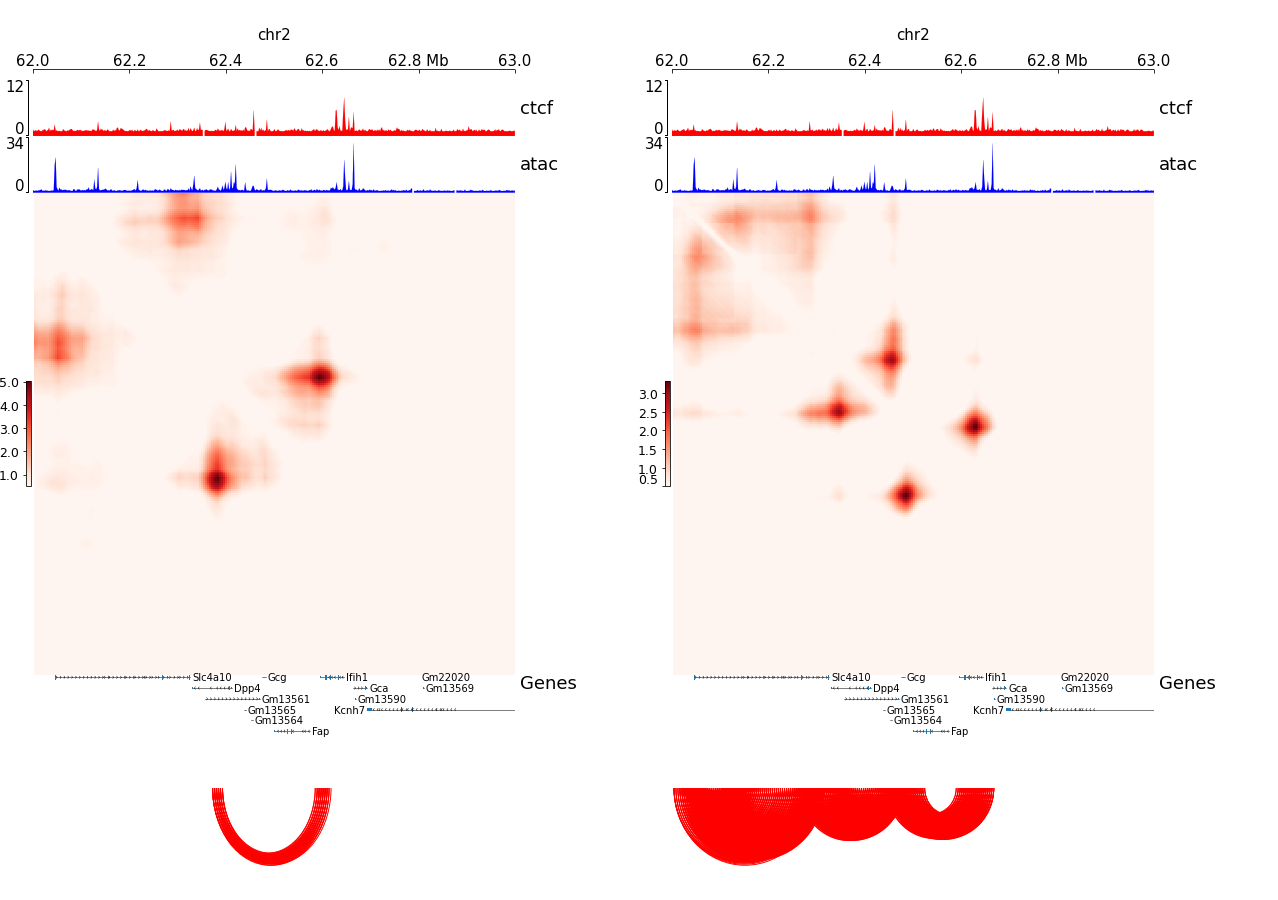

In [10]:
display_images('outputs/baseline_129_b6_5kb_chr2_62000000_ctcf_true_tracks.png', 
               'outputs/baseline_129_b6_5kb_chr2_62000000_ctcf_pred_tracks.png')

In [ ]:
! python ../src/cshark/inference/perturb.py \
    --celltype 129_b6_5kb \
    --outname ctcf_ko_only \
    --chr chr2 \
    --start 62000000 \
    --model /mnt/jinstore/JinLab02/dmp131/C.Shark/checkpoints/deeploop_b6_129_CTCF_ATAC_5kb.ckpt \
    --seq ../cshark_data/data/mm10/dna_sequence \
    --seq2 ../cshark_data/data/129/dna_sequence \
    --matrix-size 512 \
    --resolution 4096 \
    --region chr2:62000000-63000000 \
    --ko-start 62000000 \
    --ko-width 2000000 \
    --ko ctcf \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/mm10/129_b6_5kb/genomic_features/ctcf.bw \
              atac=../cshark_data/data/mm10/129_b6_5kb/genomic_features/atac.bw

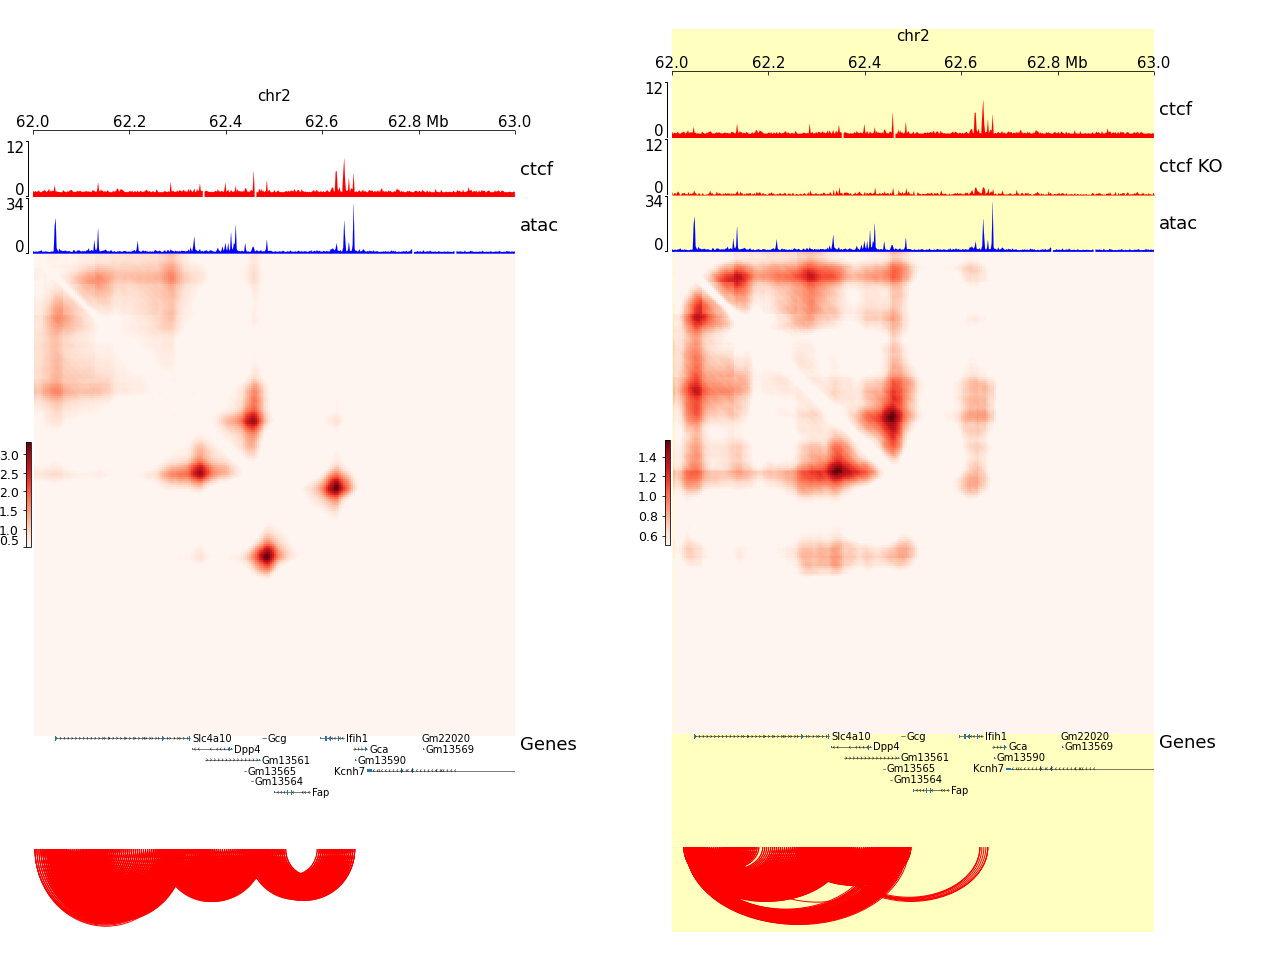

In [49]:
display_images('outputs/ctcf_ko_only_129_b6_5kb_chr2_62000000_ctcf_pred_tracks.png', 
               'outputs/ctcf_ko_only_129_b6_5kb_chr2_62000000_ctcf_ko_tracks.png')